# This jupyter notebook is to obatin and plot all results in the paper

### If you just want to try the model, I suggest you to check "try_model.ipynb"

#### For each section, you can either uncomment the first cell to run the results, or just use the second cell to take the results from a csv file

## Libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib as mpl

import torch
import torch.optim as optim

from utils.dataset import create_model_dataset, to_temporal_dataset, load_val_test_dataset
from utils.load import read_config
from utils.miscellaneous import get_model
from training.train import Trainer
from utils.miscellaneous import get_numerical_times, calculate_speed_ups, SpatialAnalysis, get_pareto_front

In [2]:
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5

mpl.rcParams['figure.figsize'] = [7, 5]
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 500
mpl.rcParams['savefig.bbox'] = 'tight'

mpl.rcParams['font.size'] = 18
mpl.rcParams['legend.fontsize'] = 'small'
mpl.rcParams['figure.titlesize'] = 'medium'

# Plots

## Functions

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_trained_model(config, model_name, model_dir):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    dataset_parameters = config['dataset_parameters']
    scalers = config['scalers']
    selected_node_features = config['selected_node_features']
    selected_edge_features = config['selected_edge_features']

    train_dataset, _, _, scalers = create_model_dataset(
        'grid', scalers=scalers, device=device, **dataset_parameters,
        **selected_node_features, **selected_edge_features
    )

    temporal_dataset_parameters = config['temporal_dataset_parameters']

    temporal_train_dataset = to_temporal_dataset(train_dataset, **temporal_dataset_parameters)

    node_features, edge_features = temporal_train_dataset[0].x.size(-1), temporal_train_dataset[0].edge_attr.size(-1)
    num_nodes, num_edges = temporal_train_dataset[0].x.size(0), temporal_train_dataset[0].edge_attr.size(0)

    previous_t = temporal_dataset_parameters['previous_t']

    model_parameters = config['models']
    model_type = model_parameters.pop('model_type')

    if model_type == 'GNN':
        model_parameters['edge_features'] = edge_features
    elif model_type == 'MLP':
        model_parameters.num_nodes = num_nodes

    model = get_model(model_type)(
        node_features=node_features,
        previous_t=previous_t,
        device=device,
        **model_parameters).to(device)

    trainer_options = config['trainer_options']
    try:
        batch_size = trainer_options.pop('batch_size')
    except:
        pass

    lr_info = config['lr_info']

    # Model optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr_info['learning_rate'], weight_decay=lr_info['weight_decay'])
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=lr_info['step_size'], gamma=lr_info['gamma'])

    # Training
    trainer = Trainer(optimizer, lr_scheduler, **trainer_options)
    trainer._load_model(model, model_name=model_name, save_dir=model_dir)

    return model, scalers



## GNN layers - K

In [4]:
# water_thresholds = [0.05, 0.3]
# temporal_resolutions = [90,30,60,120]
# all_GNN_layers = range(1,13)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# test_size = 20

# df_columns=['temporal_res', 'n_layers', f'speed-up({device})', 'h_RMSE', 'q_RMSE', 'CSI_0.05', 'CSI_0.3']
# df_mean = pd.DataFrame(columns=df_columns)
# df_std = pd.DataFrame(columns=df_columns)

# for temporal_res in temporal_resolutions:
#     results_dir = f'results/GNN_layers_temporal_res/{temporal_res}'

#     config = read_config(f'{results_dir}/config.yaml')
#     config['dataset_parameters']['test_size'] = test_size
#     val_dataset, _, temporal_test_dataset_parameters = load_val_test_dataset(config)

#     test_dataset = val_dataset
#     maximum_time = test_dataset[0].WD.shape[1]

#     dataset_parameters = config['dataset_parameters']
#     temporal_res = dataset_parameters['temporal_res']

#     numerical_times = get_numerical_times(test_size, temporal_res, maximum_time, 
#                     **temporal_test_dataset_parameters,
#                     overview_file='database/raw_datasets/overview.csv')

#     for GNN_layers in all_GNN_layers:
#         try:
#             config['models']['model_type'] = 'GNN'
#             config['models']['K'] = GNN_layers
#             model, scalers = load_trained_model(config, f'GNN_{GNN_layers}.h5', model_dir=results_dir)
#         except:
#             print(f'Combination: {GNN_layers} GNN layers and {temporal_res} min temporal resolution not found!')
#             continue
        
#         spatial_analyser = SpatialAnalysis(model, test_dataset, **temporal_test_dataset_parameters)
#         rollout_loss = spatial_analyser._get_rollout_loss(type_loss='RMSE')
#         model_times = spatial_analyser.prediction_times
#         avg_speedup, std_speedup = calculate_speed_ups(numerical_times, model_times)

#         CSIs = torch.stack([spatial_analyser._get_CSI(wt) for wt in water_thresholds], 1).mean(2).to('cpu')

#         df = pd.DataFrame([[temporal_res, GNN_layers, avg_speedup,
#                 rollout_loss.mean(0)[0].item(), rollout_loss.mean(0)[1:].mean().item(),
#                 CSIs.mean(0)[0].item(), CSIs.mean(0)[1].item()]], columns=df_columns)
#         df_mean = pd.concat([df, df_mean], axis=0)

#         df = pd.DataFrame([[temporal_res, GNN_layers, std_speedup,
#                 rollout_loss.std(0)[0].item(), rollout_loss.std(0)[1:].mean().item(),
#                 CSIs.std(0)[0].item(), CSIs.std(0)[1].item()]], columns=df_columns)
#         df_std = pd.concat([df, df_std], axis=0)

# df_mean.to_csv('results/GNN_layers_temporal_res/overview_mean.csv', index=False)
# df_std.to_csv('results/GNN_layers_temporal_res/overview_std.csv', index=False)

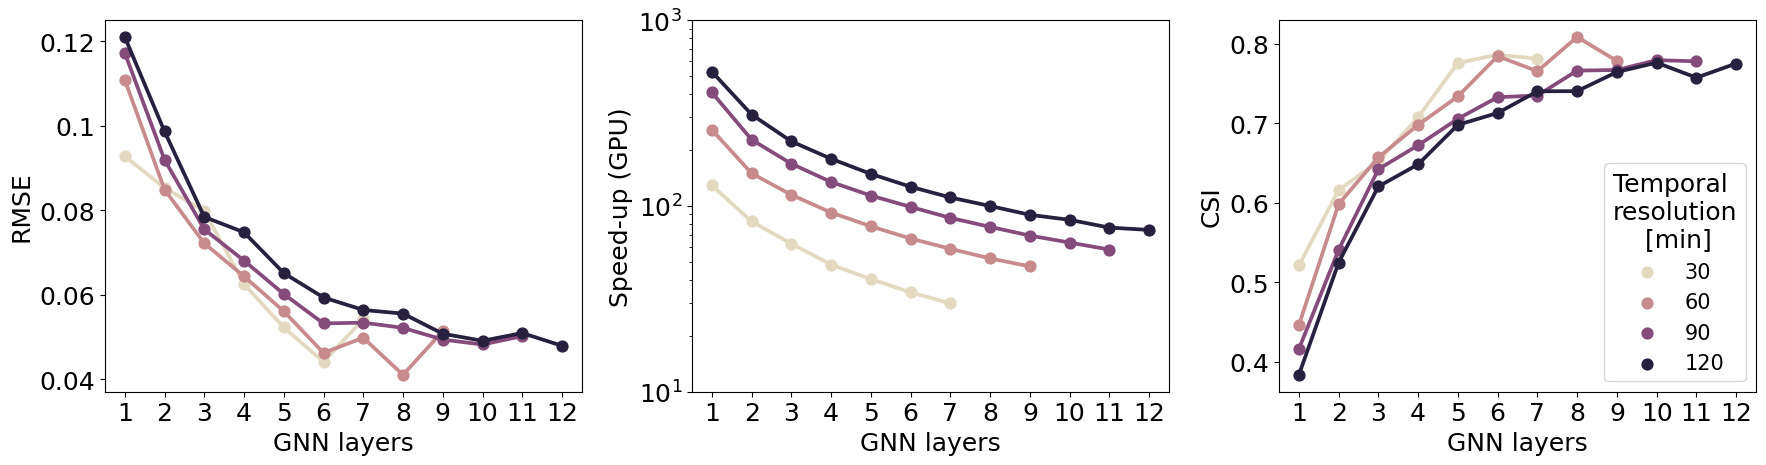

In [5]:
device = 'cuda'
df_mean = pd.read_csv('results/GNN_layers_temporal_res/overview_mean_GPU.csv')
df_std = pd.read_csv('results/GNN_layers_temporal_res/overview_std_GPU.csv')

df_mean = df_mean.drop([21,29])
df_mean['RMSE'] = (df_mean['h_RMSE'] + df_mean['q_RMSE'])/2
df_mean['CSI'] = (df_mean['CSI_0.05'] + df_mean['CSI_0.3'])/2

fig, axs = plt.subplots(1, 3, figsize=(18,5))

sns.pointplot(df_mean, x='n_layers', y='RMSE', hue='temporal_res', palette="ch:s=-.2,r=.6", ax=axs[0])
sns.pointplot(df_mean, x='n_layers', y=f'speed-up({device})', hue='temporal_res', palette="ch:s=-.2,r=.6", ax=axs[1])
sns.pointplot(df_mean, x='n_layers', y='CSI', hue='temporal_res', palette="ch:s=-.2,r=.6", ax=axs[2])
axs[0].legend([],[], frameon=False)
axs[1].legend([],[], frameon=False)
axs[2].legend(title='Temporal\nresolution\n    [min]')

axs[1].set_ylim(10,1000)
axs[1].set_yscale('log')
axs[0].set_yticks([0.04, 0.06, 0.08, 0.1, 0.12])
axs[0].set_yticklabels([0.04, 0.06, 0.08, 0.1, 0.12])

axs[0].set_ylabel('RMSE')
axs[1].set_ylabel('Speed-up (GPU)')
axs[2].set_ylabel('CSI')

axs[0].set_xlabel('GNN layers')
axs[1].set_xlabel('GNN layers')
axs[2].set_xlabel('GNN layers')

plt.tight_layout()

## Pareto-front

In [5]:
# water_thresholds = [0.05, 0.3]
# all_hid_features = [8, 16, 32, 64]
# all_GNN_layers = range(1,10)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# df_columns=['hid_features', 'n_layers', 'total_parameters', f'speed-up({device})', 'h_RMSE', 'q_RMSE', 'CSI_0.05', 'CSI_0.3']
# df_mean = pd.DataFrame(columns=df_columns)
# df_std = pd.DataFrame(columns=df_columns)

# results_dir = f'results/Pareto_front'

# config = read_config(f'{results_dir}/config.yaml')
# test_size = config['dataset_parameters']['test_size'] = 5
# val_dataset, test_dataset, temporal_test_dataset_parameters = load_val_test_dataset(config)

# test_size = len(val_dataset)
# test_dataset = val_dataset
# maximum_time = test_dataset[0].WD.shape[1]

# dataset_parameters = config['dataset_parameters']
# temporal_res = dataset_parameters['temporal_res']

# numerical_times = get_numerical_times(test_size, temporal_res, maximum_time, 
#                 **temporal_test_dataset_parameters,
#                 overview_file='database/raw_datasets/overview.csv')

# for hid_features in all_hid_features:
#     for GNN_layers in all_GNN_layers:
#         try:
#             config['models']['model_type'] = 'GNN'
#             config['models']['K'] = GNN_layers
#             config['models']['hid_features'] = hid_features
#             model, scalers = load_trained_model(config, f'GNN_{hid_features}F_{GNN_layers}L.h5', model_dir=results_dir)
#         except:
#             print(f'Combination: {GNN_layers} GNN layers and {hid_features} hidden features not found!')
#             continue

#         total_parameteres = sum(p.numel() for p in model.parameters())
#         spatial_analyser = SpatialAnalysis(model, test_dataset, **temporal_test_dataset_parameters)
#         rollout_loss = spatial_analyser._get_rollout_loss(type_loss='RMSE')
#         model_times = spatial_analyser.prediction_times
#         avg_speedup, std_speedup = calculate_speed_ups(numerical_times, model_times)

#         CSIs = torch.stack([spatial_analyser._get_CSI(wt) for wt in water_thresholds], 1).mean(2).to('cpu')

#         df = pd.DataFrame([[hid_features, GNN_layers, total_parameteres, avg_speedup,
#                 rollout_loss.mean(0)[0].item(), rollout_loss.mean(0)[1:].mean().item(),
#                 CSIs.mean(0)[0].item(), CSIs.mean(0)[1].item()]], columns=df_columns)
#         df_mean = pd.concat([df, df_mean], axis=0)

#         df = pd.DataFrame([[hid_features, GNN_layers, total_parameteres, std_speedup,
#                 rollout_loss.std(0)[0].item(), rollout_loss.std(0)[1:].mean().item(),
#                 CSIs.std(0)[0].item(), CSIs.std(0)[1].item()]], columns=df_columns)
#         df_std = pd.concat([df, df_std], axis=0)

# df_mean.to_csv(f'{results_dir}/overview_mean.csv', index=False)
# df_std.to_csv(f'{results_dir}/overview_std.csv', index=False)

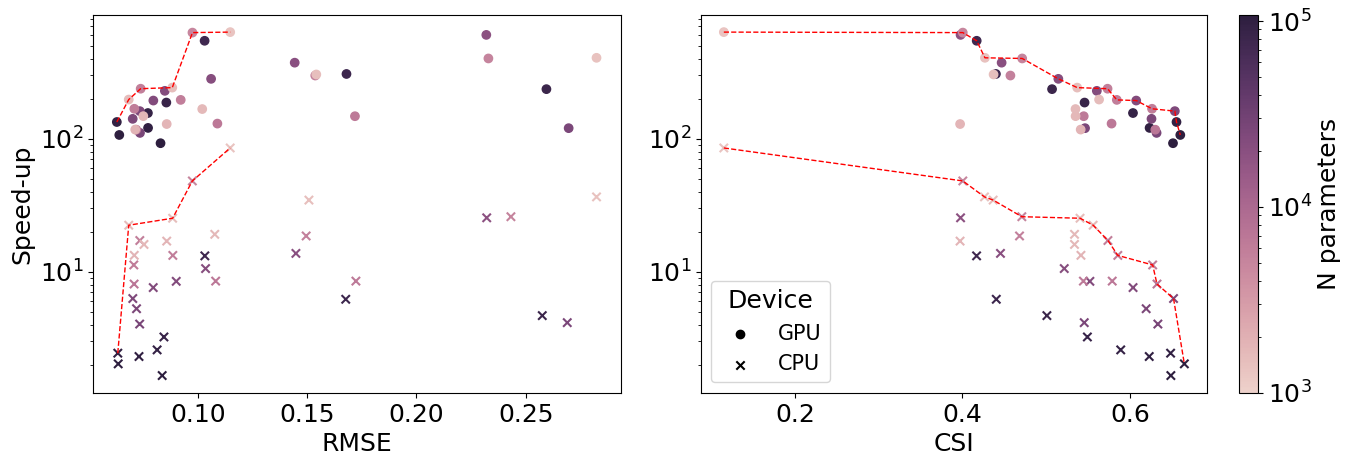

In [7]:
df_mean_GPU = pd.read_csv('results/Pareto_front/overview_mean_big_GPU.csv')
df_std_GPU = pd.read_csv('results/Pareto_front/overview_std_big_GPU.csv')

df_mean_GPU['RMSE'] = (df_mean_GPU['h_RMSE'] + df_mean_GPU['q_RMSE'])/2
df_mean_GPU['CSI'] = (df_mean_GPU['CSI_0.05'] + df_mean_GPU['CSI_0.3'])/2

df_mean_CPU = pd.read_csv('results/Pareto_front/overview_big_mean_CPU.csv')
df_std_CPU = pd.read_csv('results/Pareto_front/overview_big_std_CPU.csv')

df_mean_CPU['RMSE'] = (df_mean_CPU['h_RMSE'] + df_mean_CPU['q_RMSE'])/2
df_mean_CPU['CSI'] = (df_mean_CPU['CSI_0.05'] + df_mean_CPU['CSI_0.3'])/2

fig, axs = plt.subplots(1,2, figsize=(14,5), gridspec_kw={'width_ratios': [1, 1.2]})

cmap = sns.color_palette("ch:s=-.2,r=.6", as_cmap=True)
cmap = sns.cubehelix_palette(as_cmap=True)

axs[1].scatter(df_mean_GPU['CSI'], df_mean_GPU[f'speed-up(cuda)'], c=df_mean_GPU['total_parameters'], 
               norm=mpl.colors.LogNorm(vmin=1000), cmap=cmap, marker='o')
scat = axs[1].scatter(df_mean_CPU['CSI'], df_mean_CPU[f'speed-up(cpu)'], c=df_mean_CPU['total_parameters'], 
               norm=mpl.colors.LogNorm(vmin=1000), cmap=cmap, marker='x')

axs[1].scatter(x=[], y=[], c='k', marker='o', label='GPU')
axs[1].scatter(x=[], y=[], c='k', marker='x', label='CPU')

pareto_front = get_pareto_front(df_mean_GPU, 'speed-up(cuda)', 'CSI', ascending=False)
axs[1].plot(pareto_front[:,1], pareto_front[:,0], 'r--', linewidth=1, marker='')

pareto_front = get_pareto_front(df_mean_CPU, 'speed-up(cpu)', 'CSI', ascending=False)
axs[1].plot(pareto_front[:,1], pareto_front[:,0], 'r--', linewidth=1, marker='')

axs[0].set_ylabel('Speed-up')
axs[1].set_xlabel('CSI')

axs[0].scatter(df_mean_GPU['RMSE'], df_mean_GPU[f'speed-up(cuda)'], c=df_mean_GPU['total_parameters'], 
                norm=mpl.colors.LogNorm(vmin=1000), cmap=cmap, marker='o')
axs[0].scatter(df_mean_CPU['RMSE'], df_mean_CPU[f'speed-up(cpu)'], c=df_mean_CPU['total_parameters'], 
                norm=mpl.colors.LogNorm(vmin=1000), cmap=cmap, marker='x')

pareto_front = get_pareto_front(df_mean_GPU, 'RMSE', 'speed-up(cuda)', ascending=True)
axs[0].plot(pareto_front[:,0], pareto_front[:,1], 'r--', linewidth=1, marker='')

pareto_front = get_pareto_front(df_mean_CPU, 'RMSE', 'speed-up(cpu)', ascending=True)
axs[0].plot(pareto_front[:,0], pareto_front[:,1], 'r--', linewidth=1, marker='')

axs[0].set_xlabel('RMSE')

clb = plt.colorbar(scat, ax=axs[1])
clb.set_label('N parameters')

axs[1].legend(title='Device', loc=3)
axs[0].set_yscale('log')
axs[1].set_yscale('log')
plt.tight_layout()

## Training strategy

### Multi-step-ahead (rollout steps)

In [1]:
# water_thresholds = [0.05, 0.3]
# rollout_steps = range(1,10)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# df_columns=['rollout_steps', 'h_RMSE', 'q_RMSE', 'CSI_0.05', 'CSI_0.3']
# df_mean = pd.DataFrame(columns=df_columns)
# df_std = pd.DataFrame(columns=df_columns)

# results_dir = f'results/training_strategy/training_steps'

# config = read_config(f'{results_dir}/config.yaml')
# test_size = config['dataset_parameters']['test_size'] = 20
# val_dataset, test_dataset, temporal_test_dataset_parameters = load_val_test_dataset(config)

# test_dataset = val_dataset

# for rollout_step in rollout_steps:
#     try:
#         config['models']['model_type'] = 'GNN'        
#         model, scalers = load_trained_model(config, f'GNN_{rollout_step}.h5', model_dir=results_dir)
#     except:
#         print(f'Combination: GNN with {rollout_step} rollout steps not found!')
#         continue

#     total_parameteres = sum(p.numel() for p in model.parameters())
#     spatial_analyser = SpatialAnalysis(model, test_dataset, **temporal_test_dataset_parameters)
#     rollout_loss = spatial_analyser._get_rollout_loss(type_loss='RMSE')
    
#     CSIs = torch.stack([spatial_analyser._get_CSI(wt) for wt in water_thresholds], 1).mean(2).to('cpu')

#     df = pd.DataFrame([[rollout_step, rollout_loss.mean(0)[0].item(), rollout_loss.mean(0)[1:].mean().item(),
#             CSIs.mean(0)[0].item(), CSIs.mean(0)[1].item()]], columns=df_columns)
#     df_mean = pd.concat([df, df_mean], axis=0)

#     df = pd.DataFrame([[rollout_step, rollout_loss.std(0)[0].item(), rollout_loss.std(0)[1:].mean().item(),
#             CSIs.std(0)[0].item(), CSIs.std(0)[1].item()]], columns=df_columns)
#     df_std = pd.concat([df, df_std], axis=0)

# df_mean.to_csv(f'{results_dir}/overview_mean_GPU.csv', index=False)
# df_std.to_csv(f'{results_dir}/overview_std_GPU.csv', index=False)

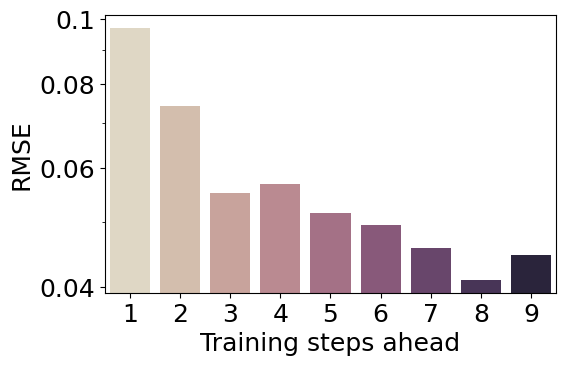

In [7]:
df_mean = pd.read_csv('results/training_strategy/training_steps/overview_mean_GPU.csv')
df_std = pd.read_csv('results/training_strategy/training_steps/overview_std_GPU.csv')

df_mean['RMSE'] = (df_mean['h_RMSE'] + df_mean['q_RMSE'])/2
df_mean['CSI'] = (df_mean['CSI_0.05'] + df_mean['CSI_0.3'])/2

fig, ax = plt.subplots(1, 1, figsize=(6,4))

sns.barplot(df_mean, x='rollout_steps', y='RMSE', ax=ax, palette='ch:s=-.2,r=.6')

ax.set_yscale('log')

ax.set_ylabel('RMSE')
ax.set_yticks([0.04, 0.06, 0.08, 0.1])
ax.set_yticklabels([0.04, 0.06, 0.08, 0.1])
ax.set_xlabel('Training steps ahead')

plt.tight_layout()

### Curriculum learning

In [76]:
# water_thresholds = [0.05, 0.3]
# curriculum_steps = [0,5,10,15,20,25]

# training_times = {
#     0: 94517,
#     5: 86385,
#     10: 78280,
#     15: 72725,
#     20: 62686,
#     25: 52260}

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# df_columns=['curriculum_steps', 'training_time', 'h_RMSE', 'q_RMSE', 'CSI_0.05', 'CSI_0.3']
# df_mean = pd.DataFrame(columns=df_columns)
# df_std = pd.DataFrame(columns=df_columns)

# results_dir = f'results/training_strategy/curriculum_learning'

# config = read_config(f'{results_dir}/config.yaml')
# test_size = config['dataset_parameters']['test_size'] = 5
# val_dataset, test_dataset, temporal_test_dataset_parameters = load_val_test_dataset(config)

# test_dataset = val_dataset

# for curriculum_epochs in curriculum_steps:
#     try:
#         config['models']['model_type'] = 'GNN'
#         model, scalers = load_trained_model(config, f'GNN_{curriculum_epochs}.h5', model_dir=results_dir)
#     except:
#         print(f'Combination: GNN with {curriculum_epochs} curriculum steps not found!')
#         continue

#     total_parameteres = sum(p.numel() for p in model.parameters())
#     spatial_analyser = SpatialAnalysis(model, test_dataset, **temporal_test_dataset_parameters)
#     rollout_loss = spatial_analyser._get_rollout_loss(type_loss='RMSE')
    
#     CSIs = torch.stack([spatial_analyser._get_CSI(wt) for wt in water_thresholds], 1).mean(2).to('cpu')

#     df = pd.DataFrame([[curriculum_epochs, training_times[curriculum_epochs],
#             rollout_loss.mean(0)[0].item(), rollout_loss.mean(0)[1:].mean().item(),
#             CSIs.mean(0)[0].item(), CSIs.mean(0)[1].item()]], columns=df_columns)
#     df_mean = pd.concat([df, df_mean], axis=0)

#     df = pd.DataFrame([[curriculum_epochs, training_times[curriculum_epochs],
#             rollout_loss.std(0)[0].item(), rollout_loss.std(0)[1:].mean().item(),
#             CSIs.std(0)[0].item(), CSIs.std(0)[1].item()]], columns=df_columns)
#     df_std = pd.concat([df, df_std], axis=0)

# df_mean.to_csv(f'{results_dir}/overview_mean_CPU.csv', index=False)
# df_std.to_csv(f'{results_dir}/overview_std_CPU.csv', index=False)

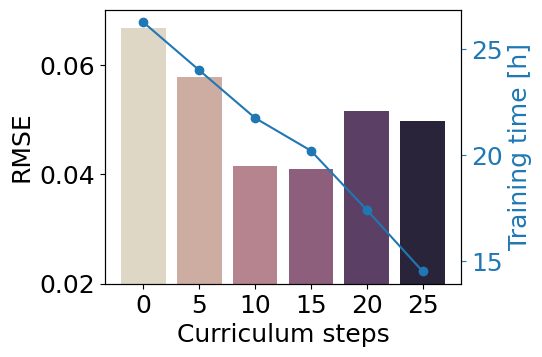

In [10]:
df_mean = pd.read_csv('results/training_strategy/curriculum_learning/overview_mean_CPU.csv')
df_std = pd.read_csv('results/training_strategy/curriculum_learning/overview_std_CPU.csv')

df_mean['RMSE'] = (df_mean['h_RMSE'] + df_mean['q_RMSE'])/2
df_mean['CSI'] = (df_mean['CSI_0.05'] + df_mean['CSI_0.3'])/2

fig, ax = plt.subplots(1, 1, figsize=(6,4))

sns.barplot(df_mean, x='curriculum_steps', y='RMSE', palette='ch:s=-.2,r=.6', ax=ax)

ax2 = ax.twinx()
p = ax2.plot(np.array(df_mean['training_time'][::-1]/3600), marker='o')[0]

ax.set_ylabel('RMSE')
ax.set_ylim(bottom=0.02)
ax2.set_ylabel('Training time [h]', c=p.get_color())
ax2.tick_params(axis='y', colors=p.get_color())

ax.set_xlabel('Curriculum steps')

plt.tight_layout()

## Model comparison

### Best models

In [50]:
# water_thresholds = [0.05, 0.3]
# model_types = ['CNN', 'SWEGNN']
# model_types = ['CNN', 'GAT', 'GNN_L', 'SWEGNN_ng', 'SWEGNN']

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# df_columns=['model_type', 'h_RMSE', 'q_RMSE', 'h_MAE', 'q_MAE', 'CSI_0.05', 'CSI_0.3', f'speed-up({device})', 'total_parameters']
# df_mean = pd.DataFrame(columns=df_columns)
# df_std = pd.DataFrame(columns=df_columns)

# results_dir = f'results/best_models'

# config = read_config(f'{results_dir}/config.yaml')
# test_size = config['dataset_parameters']['test_size'] = 'random_breach'
# test_size = config['dataset_parameters']['test_size'] = 20
# _, test_dataset, temporal_test_dataset_parameters = load_val_test_dataset(config)

# maximum_time = test_dataset[0].WD.shape[1]

# dataset_parameters = config['dataset_parameters']
# temporal_res = dataset_parameters['temporal_res']

# numerical_times = get_numerical_times(test_size, temporal_res, maximum_time, 
#                 **temporal_test_dataset_parameters,
#                 overview_file='database/raw_datasets/overview.csv')

# for model_type in model_types:
#     try:
#         results_dir_internal = f'{results_dir}/{model_type}'
#         config = read_config(f'{results_dir_internal}/config.yaml')
#         if model_type in ['GNN_L', 'GAT', 'SWEGNN_ng', 'SWEGNN']:
#             config['models']['model_type'] = 'GNN'
#         model, scalers = load_trained_model(config, f'{model_type}.h5', model_dir=results_dir_internal)
#     except:
#         print(f'{model_type} model not found!')
#         continue
    
#     total_parameters = sum(p.numel() for p in model.parameters())
#     spatial_analyser = SpatialAnalysis(model, test_dataset, **temporal_test_dataset_parameters)
#     RMSE_rollout_loss = spatial_analyser._get_rollout_loss(type_loss='RMSE')
#     MAE_rollout_loss = spatial_analyser._get_rollout_loss(type_loss='MAE')
#     model_times = spatial_analyser.prediction_times
#     avg_speedup, std_speedup = calculate_speed_ups(numerical_times, model_times)

#     CSIs = torch.stack([spatial_analyser._get_CSI(wt) for wt in water_thresholds], 1).mean(2).to('cpu')

#     df = pd.DataFrame([[model_type, RMSE_rollout_loss.mean(0)[0].item(), RMSE_rollout_loss.mean(0)[1:].mean().item(),
#             MAE_rollout_loss.mean(0)[0].item(), MAE_rollout_loss.mean(0)[1:].mean().item(),
#             CSIs.mean(0)[0].item(), CSIs.mean(0)[1].item(), avg_speedup, total_parameters]], columns=df_columns)
#     df_mean = pd.concat([df, df_mean], axis=0)

#     df = pd.DataFrame([[model_type, RMSE_rollout_loss.std(0)[0].item(), RMSE_rollout_loss.std(0)[1:].mean().item(),
#             MAE_rollout_loss.std(0)[0].item(), MAE_rollout_loss.std(0)[1:].mean().item(),
#             CSIs.std(0)[0].item(), CSIs.std(0)[1].item(), std_speedup, 0]], columns=df_columns)
#     df_std = pd.concat([df, df_std], axis=0)

# df_mean.to_csv(f'{results_dir}/overview_mean_test1.csv', index=False)
# df_std.to_csv(f'{results_dir}/overview_std_test1.csv', index=False)

### Compare models

In [7]:
model_type = 'SWEGNN'
results_dir = f'results/best_models/{model_type}'

config = read_config(f'{results_dir}/config.yaml')

model_GNN, scalers = load_trained_model(config, f'{model_type}.h5', model_dir=results_dir)

model_type = 'CNN'
results_dir = f'results/best_models/{model_type}'

config = read_config(f'{results_dir}/config.yaml')

model_CNN, scalers = load_trained_model(config, f'{model_type}.h5', model_dir=results_dir)

config['dataset_parameters']['test_size'] = 'random_breach'
config['dataset_parameters']['test_size'] = 20
config['dataset_parameters']['test_size'] = 'big_random_breach'

val_dataset, test_dataset, temporal_test_dataset_parameters = load_val_test_dataset(config)

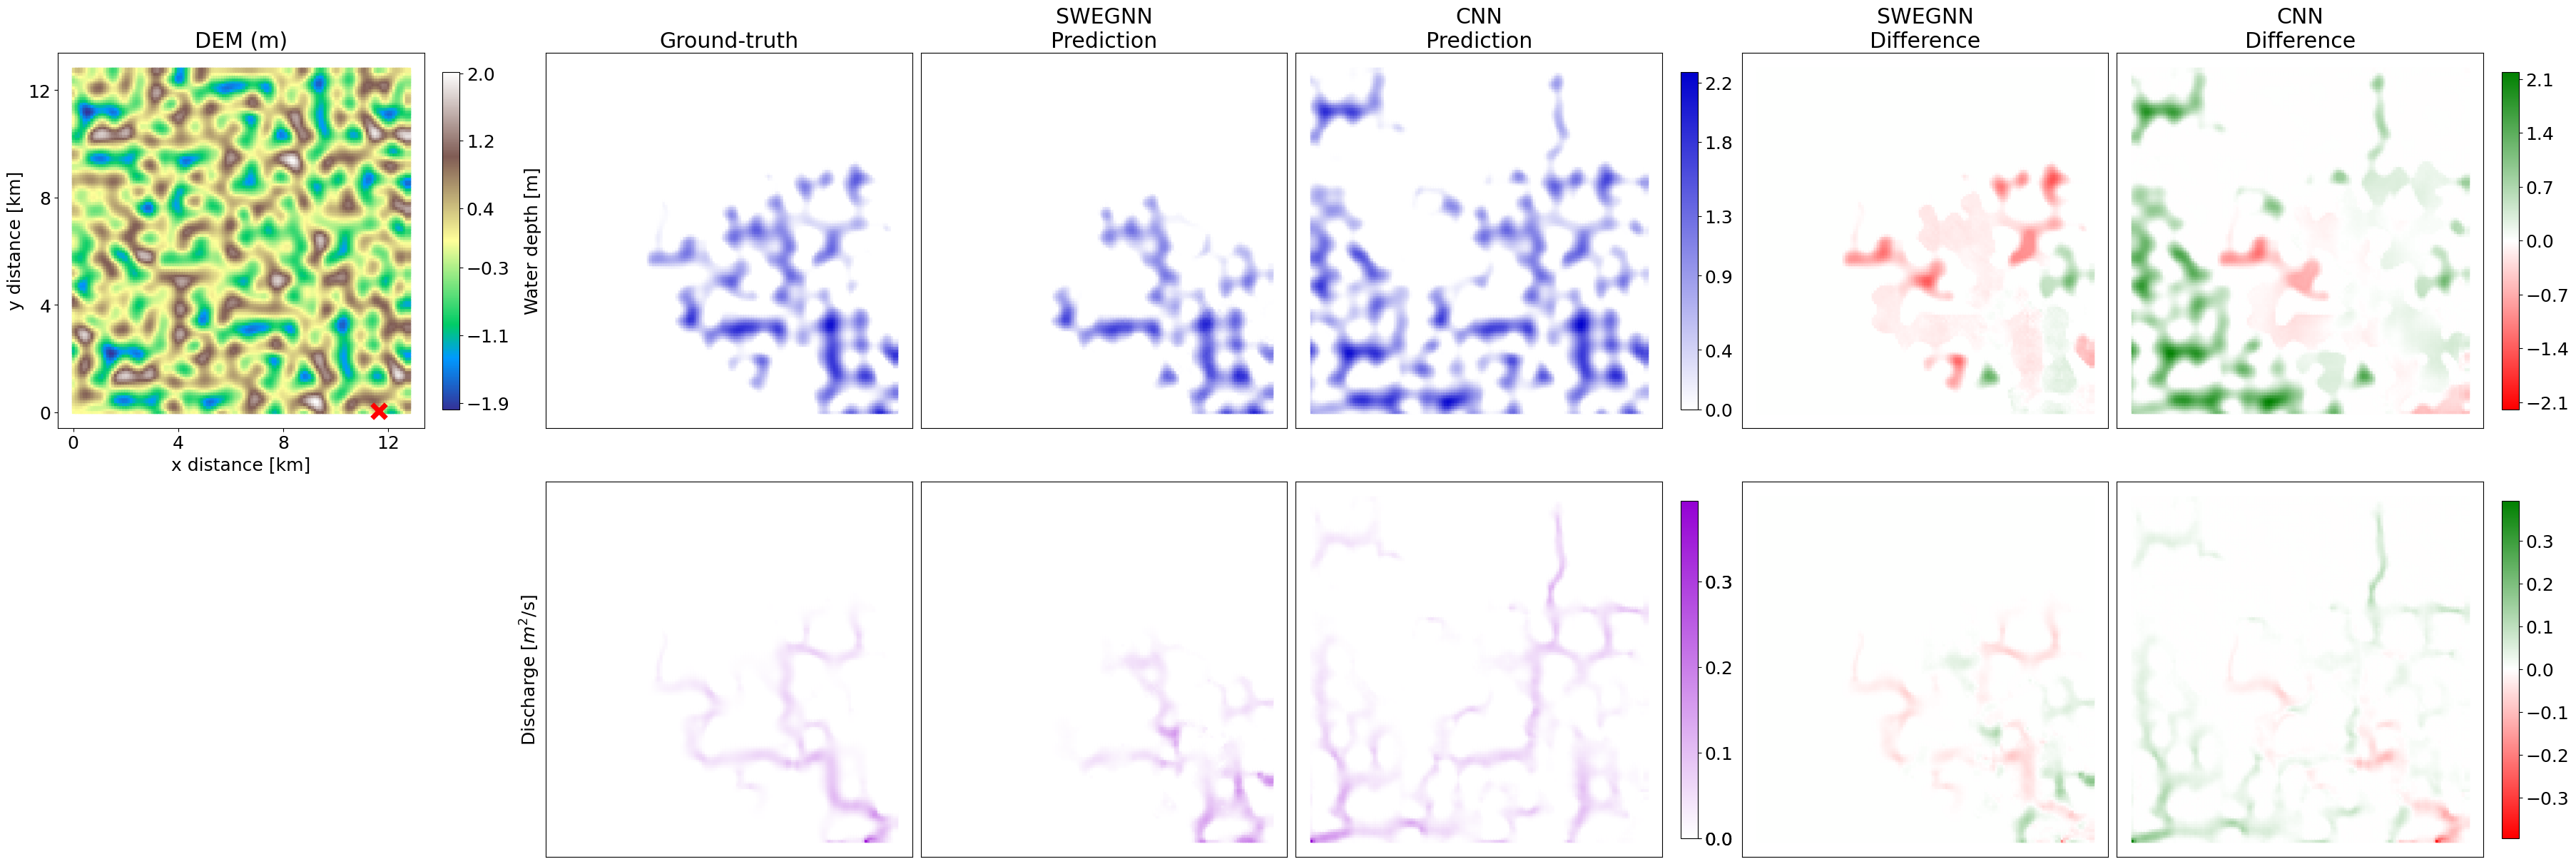

In [9]:
from utils.visualization import DoublePlotRollout

mpl.rcParams['savefig.dpi'] = 200
mpl.rcParams['font.size'] = 30

id_dataset = 1

rollout_plotter = DoublePlotRollout(model_GNN, model_CNN, test_dataset[id_dataset], scalers=scalers, 
    type_loss='RMSE', **temporal_test_dataset_parameters)

rollout_plotter.explore_rollout()

## Model Analysis

In [4]:
model_type = 'SWEGNN'
results_dir = f'results/best_models/{model_type}'

config = read_config(f'{results_dir}/config.yaml')

model, scalers = load_trained_model(config, f'{model_type}.h5', model_dir=results_dir)

config['dataset_parameters']['test_size'] = 20

val_dataset, test_dataset, temporal_test_dataset_parameters = load_val_test_dataset(config)

In [5]:
spatial_analyser = SpatialAnalysis(model, test_dataset, **temporal_test_dataset_parameters)

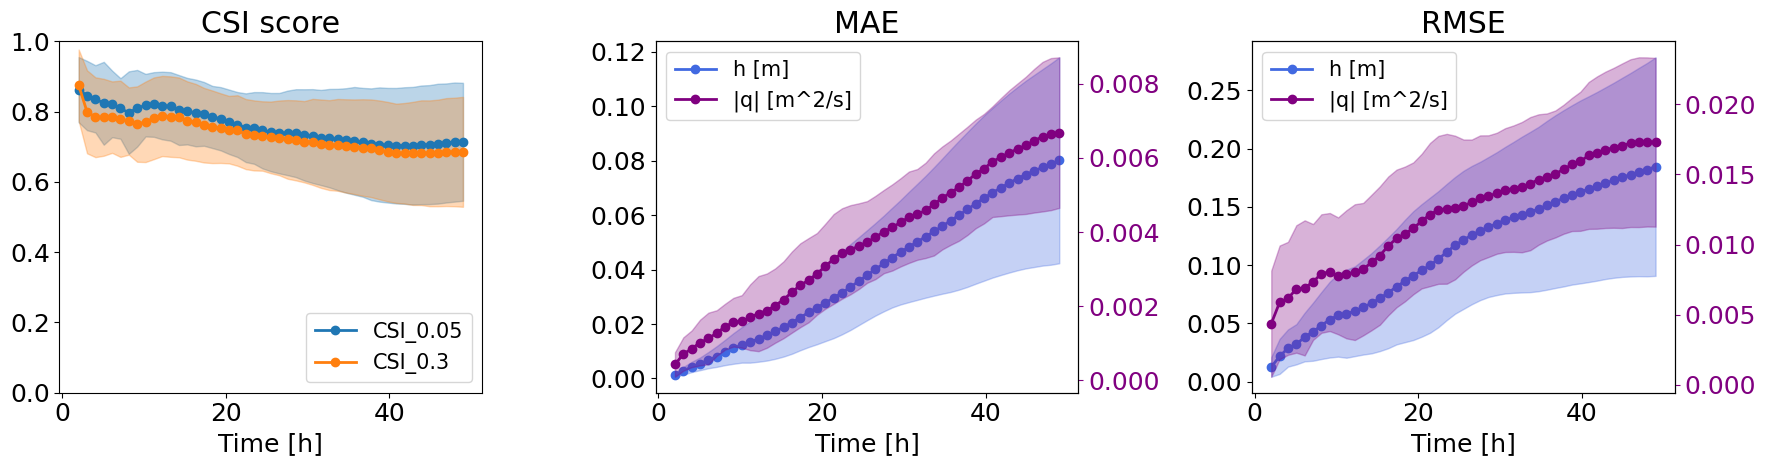

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(18,5))

_, CSI = spatial_analyser.plot_CSI_rollouts(water_thresholds=[0.05, 0.3], ax=axs[0])
_ = spatial_analyser._plot_rollouts(type_loss='RMSE', ax=axs[2])
_ = spatial_analyser._plot_rollouts(type_loss='MAE', ax=axs[1])
axs[0].grid(False)

plt.tight_layout()

In [7]:
config['dataset_parameters']['test_size'] = 'random_breach'

val_dataset, test_dataset, temporal_test_dataset_parameters = load_val_test_dataset(config)

spatial_analyser2 = SpatialAnalysis(model, test_dataset, **temporal_test_dataset_parameters)

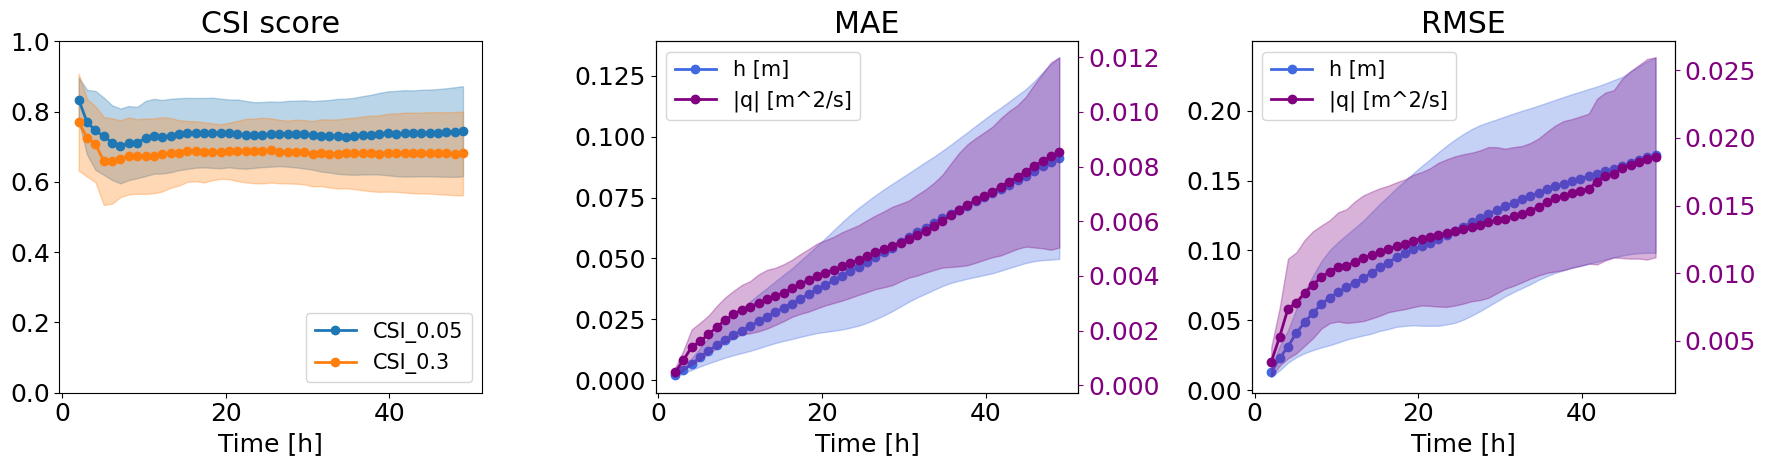

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(18,5))

_, CSI = spatial_analyser2.plot_CSI_rollouts(water_thresholds=[0.05, 0.3], ax=axs[0])
_ = spatial_analyser2._plot_rollouts(type_loss='RMSE', ax=axs[2])
_ = spatial_analyser2._plot_rollouts(type_loss='MAE', ax=axs[1])
axs[0].grid(False)

plt.tight_layout()